* <i>(First Model) <b>Faster R-CNN with ResNeXt 101 Feature Pyramid Network</b> from detectron2 [1,2],</i>
* <i>(Second Model) <b>Faster R-CNN with ResNet-50 Feature Pyramid Network</b> from detectron2 [1,2],</i>

I have used the following methods.

* I have modified the official notebook [3],
* I downloaded COCO json files [4],


## My Another Projects

* [Power Forecasting w/Online Learning (River)](https://www.kaggle.com/code/banddaniel/power-forecasting-w-online-learning-river)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Smoking Detection w/Online Learning (River)](https://www.kaggle.com/code/banddaniel/smoking-detection-w-online-learning-river)


## References
1. Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1506.01497
2. https://detectron2.readthedocs.io/en/latest/
3. https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
4. https://universe.roboflow.com/veda/bone-fracture-detection-daoon

In [1]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [2]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

detectron2 version: 0.6


In [3]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"bone_fractures_{d}", {},
                            f"../input/bone-fracture-detection-detection-coco-annots/{d}_annotations.coco.json",
                            f"../input/bone-fracture-detection-computer-vision-project/{d}/images")

In [4]:
# Examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [01/14 12:52:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 12:52:14 d2.data.datasets.coco]: Loaded 3631 images in COCO format from ../input/bone-fracture-detection-detection-coco-annots/train_annotations.coco.json


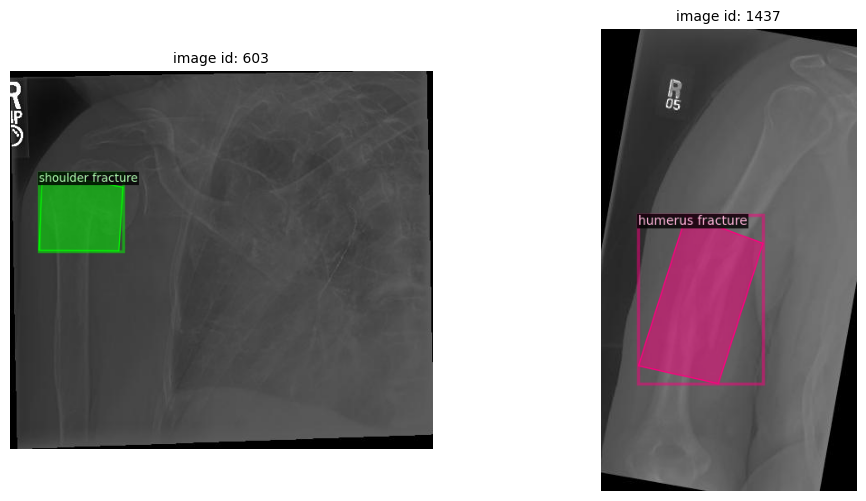

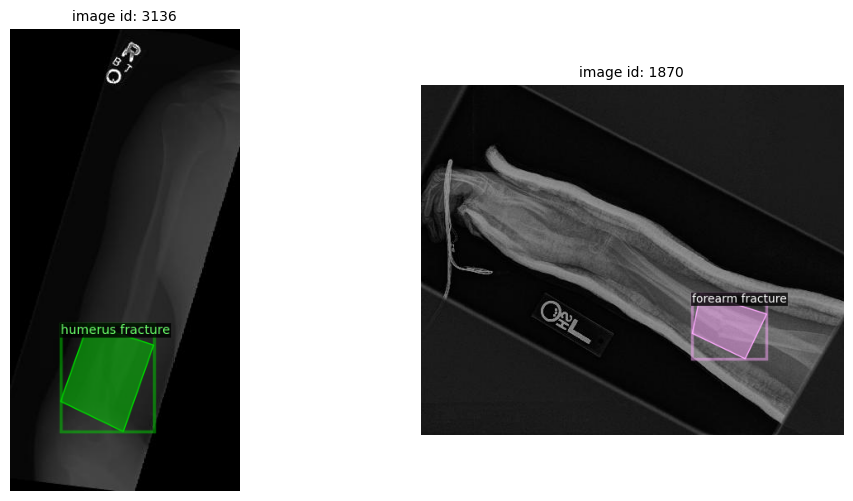

In [5]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 9 , image_scale = 1)

# <span style="color:#e74c3c;">Faster R-CNN w/ResNeXt 101 FPN </span> Model, Training

In [6]:
from detectron2.engine import DefaultTrainer

EPOCHS = 1800
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/14 12:52:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:06, 62.8MB/s]                           


[01/14 12:52:24 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/14 12:52:53 d2.utils.events]:  eta: 0:35:57  iter: 19  total_loss: 2.303  loss_cls: 2.125  loss_box_reg: 0.01214  loss_rpn_cls: 0.149  loss_rpn_loc: 0.01384    time: 1.2200  last_time: 1.3802  data_time: 0.0104  last_data_time: 0.0049   lr: 1.9981e-05  max_mem: 5716M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[01/14 12:53:27 d2.utils.events]:  eta: 0:36:05  iter: 39  total_loss: 1.445  loss_cls: 1.192  loss_box_reg: 0.03165  loss_rpn_cls: 0.1373  loss_rpn_loc: 0.01399    time: 1.2052  last_time: 1.2342  data_time: 0.0050  last_data_time: 0.0053   lr: 3.9961e-05  max_mem: 5910M
[01/14 12:53:50 d2.utils.events]:  eta: 0:34:35  iter: 59  total_loss: 0.4083  loss_cls: 0.212  loss_box_reg: 0.04218  loss_rpn_cls: 0.1482  loss_rpn_loc: 0.01269    time: 1.1756  last_time: 1.5722  data_time: 0.0051  last_data_time: 0.0046   lr: 5.9941e-05  max_mem: 5910M
[01/14 12:54:13 d2.utils.events]:  eta: 0:34:00  iter: 79  total_loss: 0.3265  loss_cls: 0.09368  loss_box_reg: 0.01857  loss_rpn_cls: 0.2067  loss_rpn_loc: 0.01629    time: 1.1700  last_time: 1.2965  data_time: 0.0057  last_data_time: 0.0063   lr: 7.9921e-05  max_mem: 5910M
[01/14 12:54:37 d2.utils.events]:  eta: 0:33:47  iter: 99  total_loss: 0.2888  loss_cls: 0.1297  loss_box_reg: 0.05661  loss_rpn_cls: 0.0892  loss_rpn_loc: 0.01006    time: 1.17

In [7]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[01/14 13:26:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# <span style="color:#e74c3c;">Faster R-CNN w/ResNeXt 101 FPN </span> Training Results

In [8]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [9]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

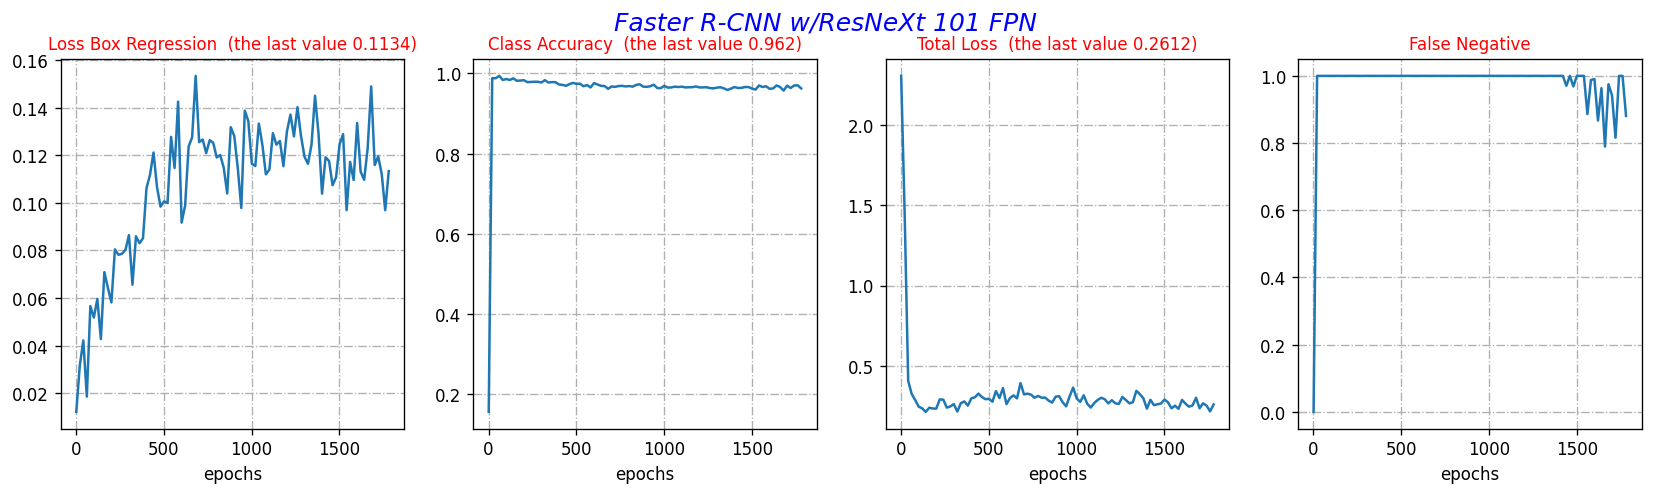

In [10]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

# <span style="color:#e74c3c;">Faster R-CNN w/ResNeXt 101 FPN </span> Test Results

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[01/14 13:27:01 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [01/14 13:27:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 13:27:01 d2.data.datasets.coco]: Loaded 169 images in COCO format from ../input/bone-fracture-detection-detection-coco-annots/test_annotations.coco.json
[01/14 13:27:01 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|     bones     | 0            | elbow posit.. | 17           | fingers pos.. | 27           |
| forearm fra.. | 14           |    humerus    | 0            | humerus fra.. | 15           |
| shoulder fr.. | 17           | wrist posit.. | 6            |               |              |
|     total     | 96           |

OrderedDict([('bbox',
              {'AP': 6.23067552031063,
               'AP50': 18.666388467734336,
               'AP75': 2.39988870617863,
               'APs': 0.057358288079616265,
               'APm': 5.761167263078822,
               'APl': 7.1192400798355315,
               'AP-bones': nan,
               'AP-elbow positive': 1.398759955430835,
               'AP-fingers positive': 3.7714494536532914,
               'AP-forearm fracture': 18.911613445859686,
               'AP-humerus': nan,
               'AP-humerus fracture': 6.058467200591692,
               'AP-shoulder fracture': 2.093724985597125,
               'AP-wrist positive': 5.150038080731148})])

# <span style="color:#e74c3c;">Faster R-CNN w/ResNeXt 101 FPN </span> Test Predictions

In [12]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [01/14 13:27:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 13:27:26 d2.data.datasets.coco]: Loaded 169 images in COCO format from ../input/bone-fracture-detection-detection-coco-annots/test_annotations.coco.json


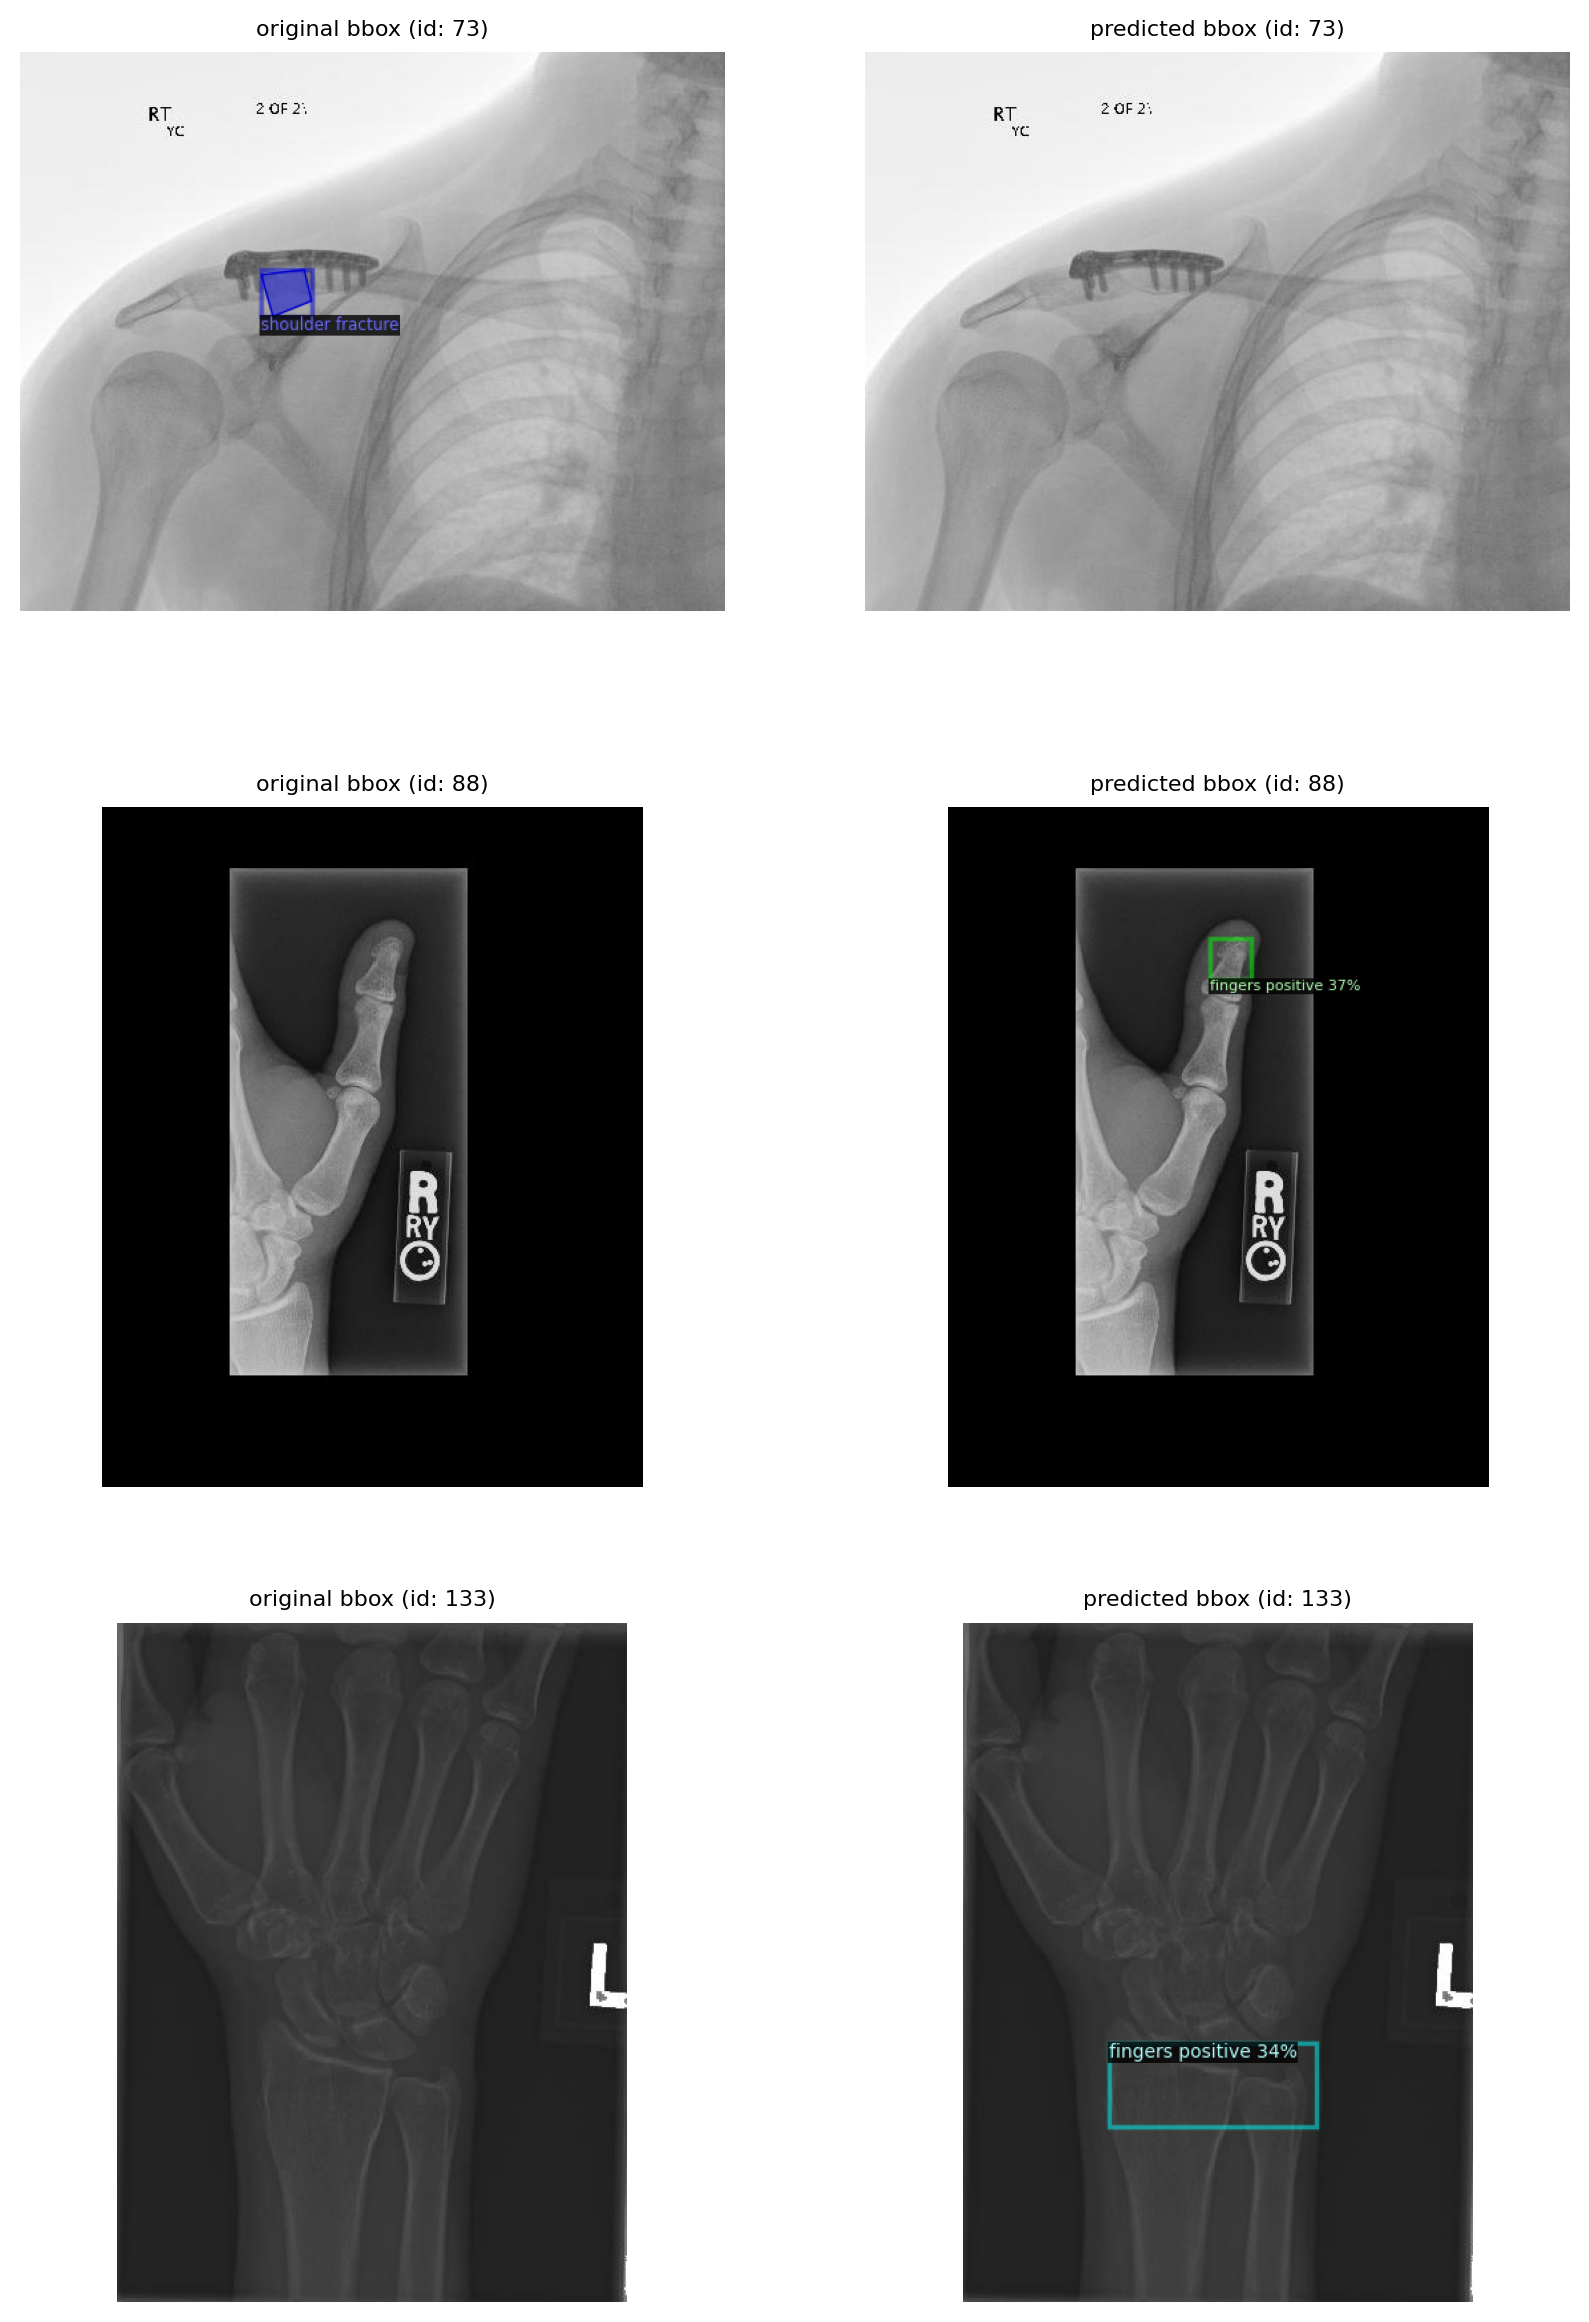

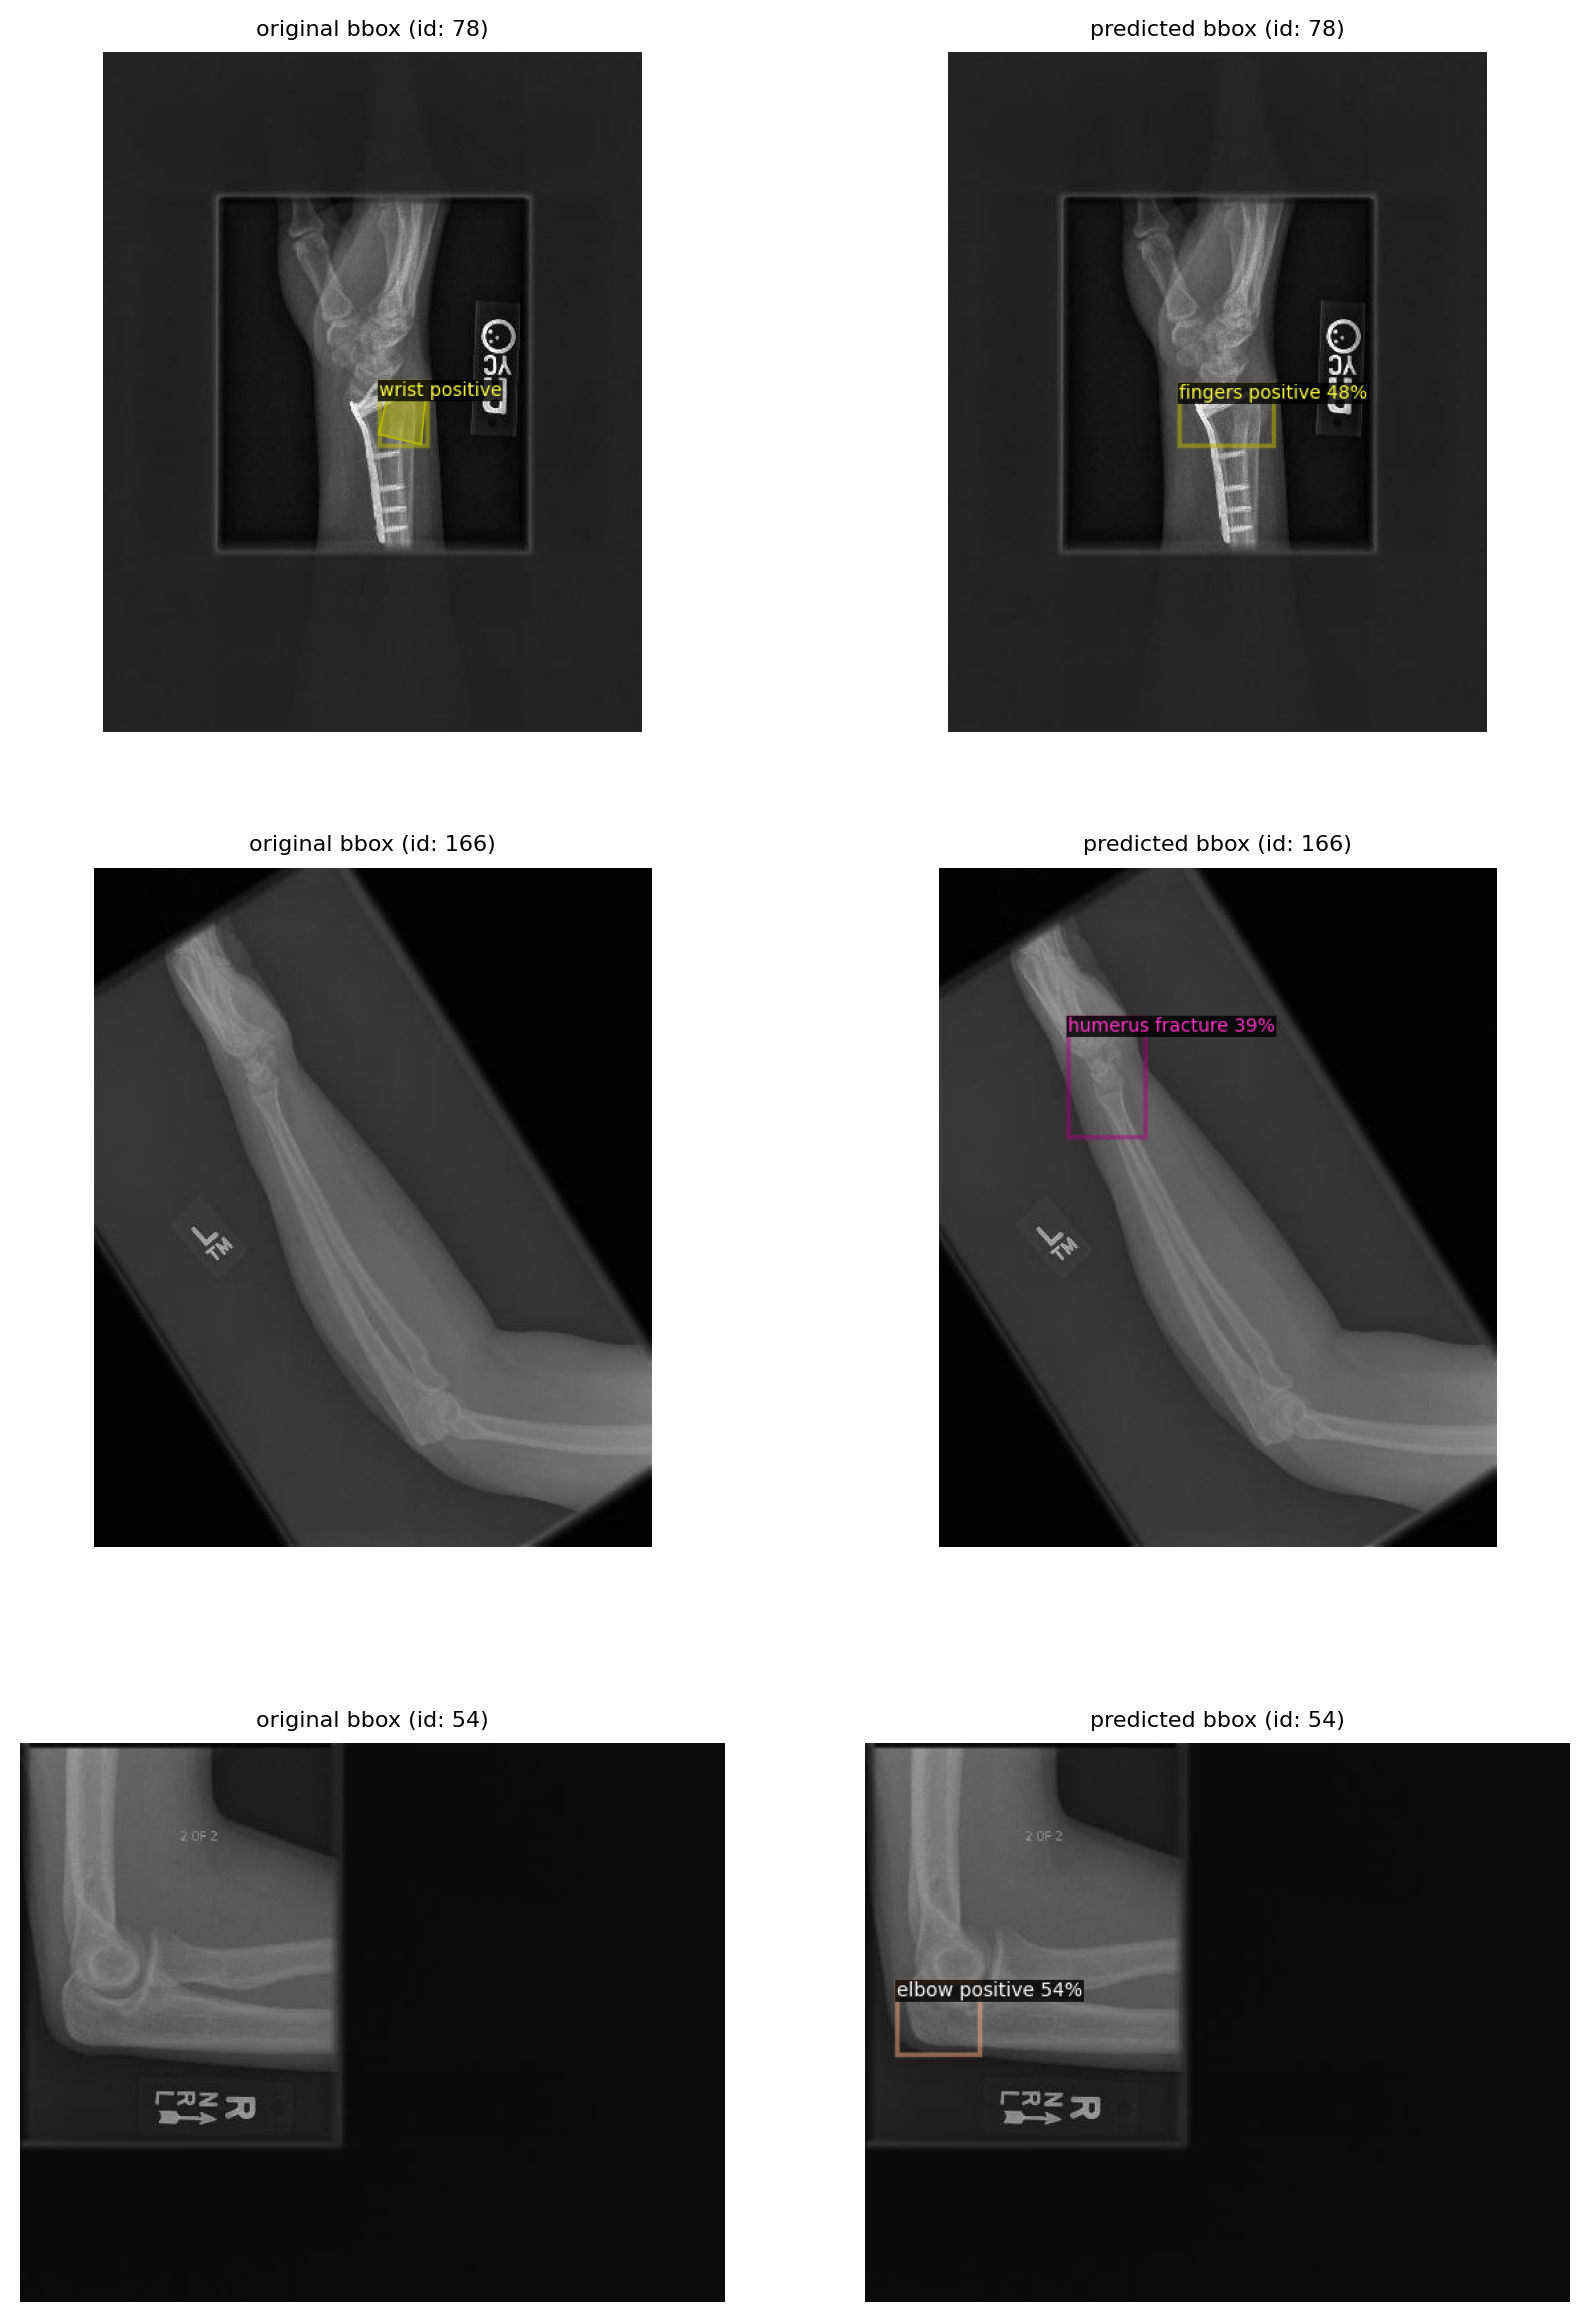

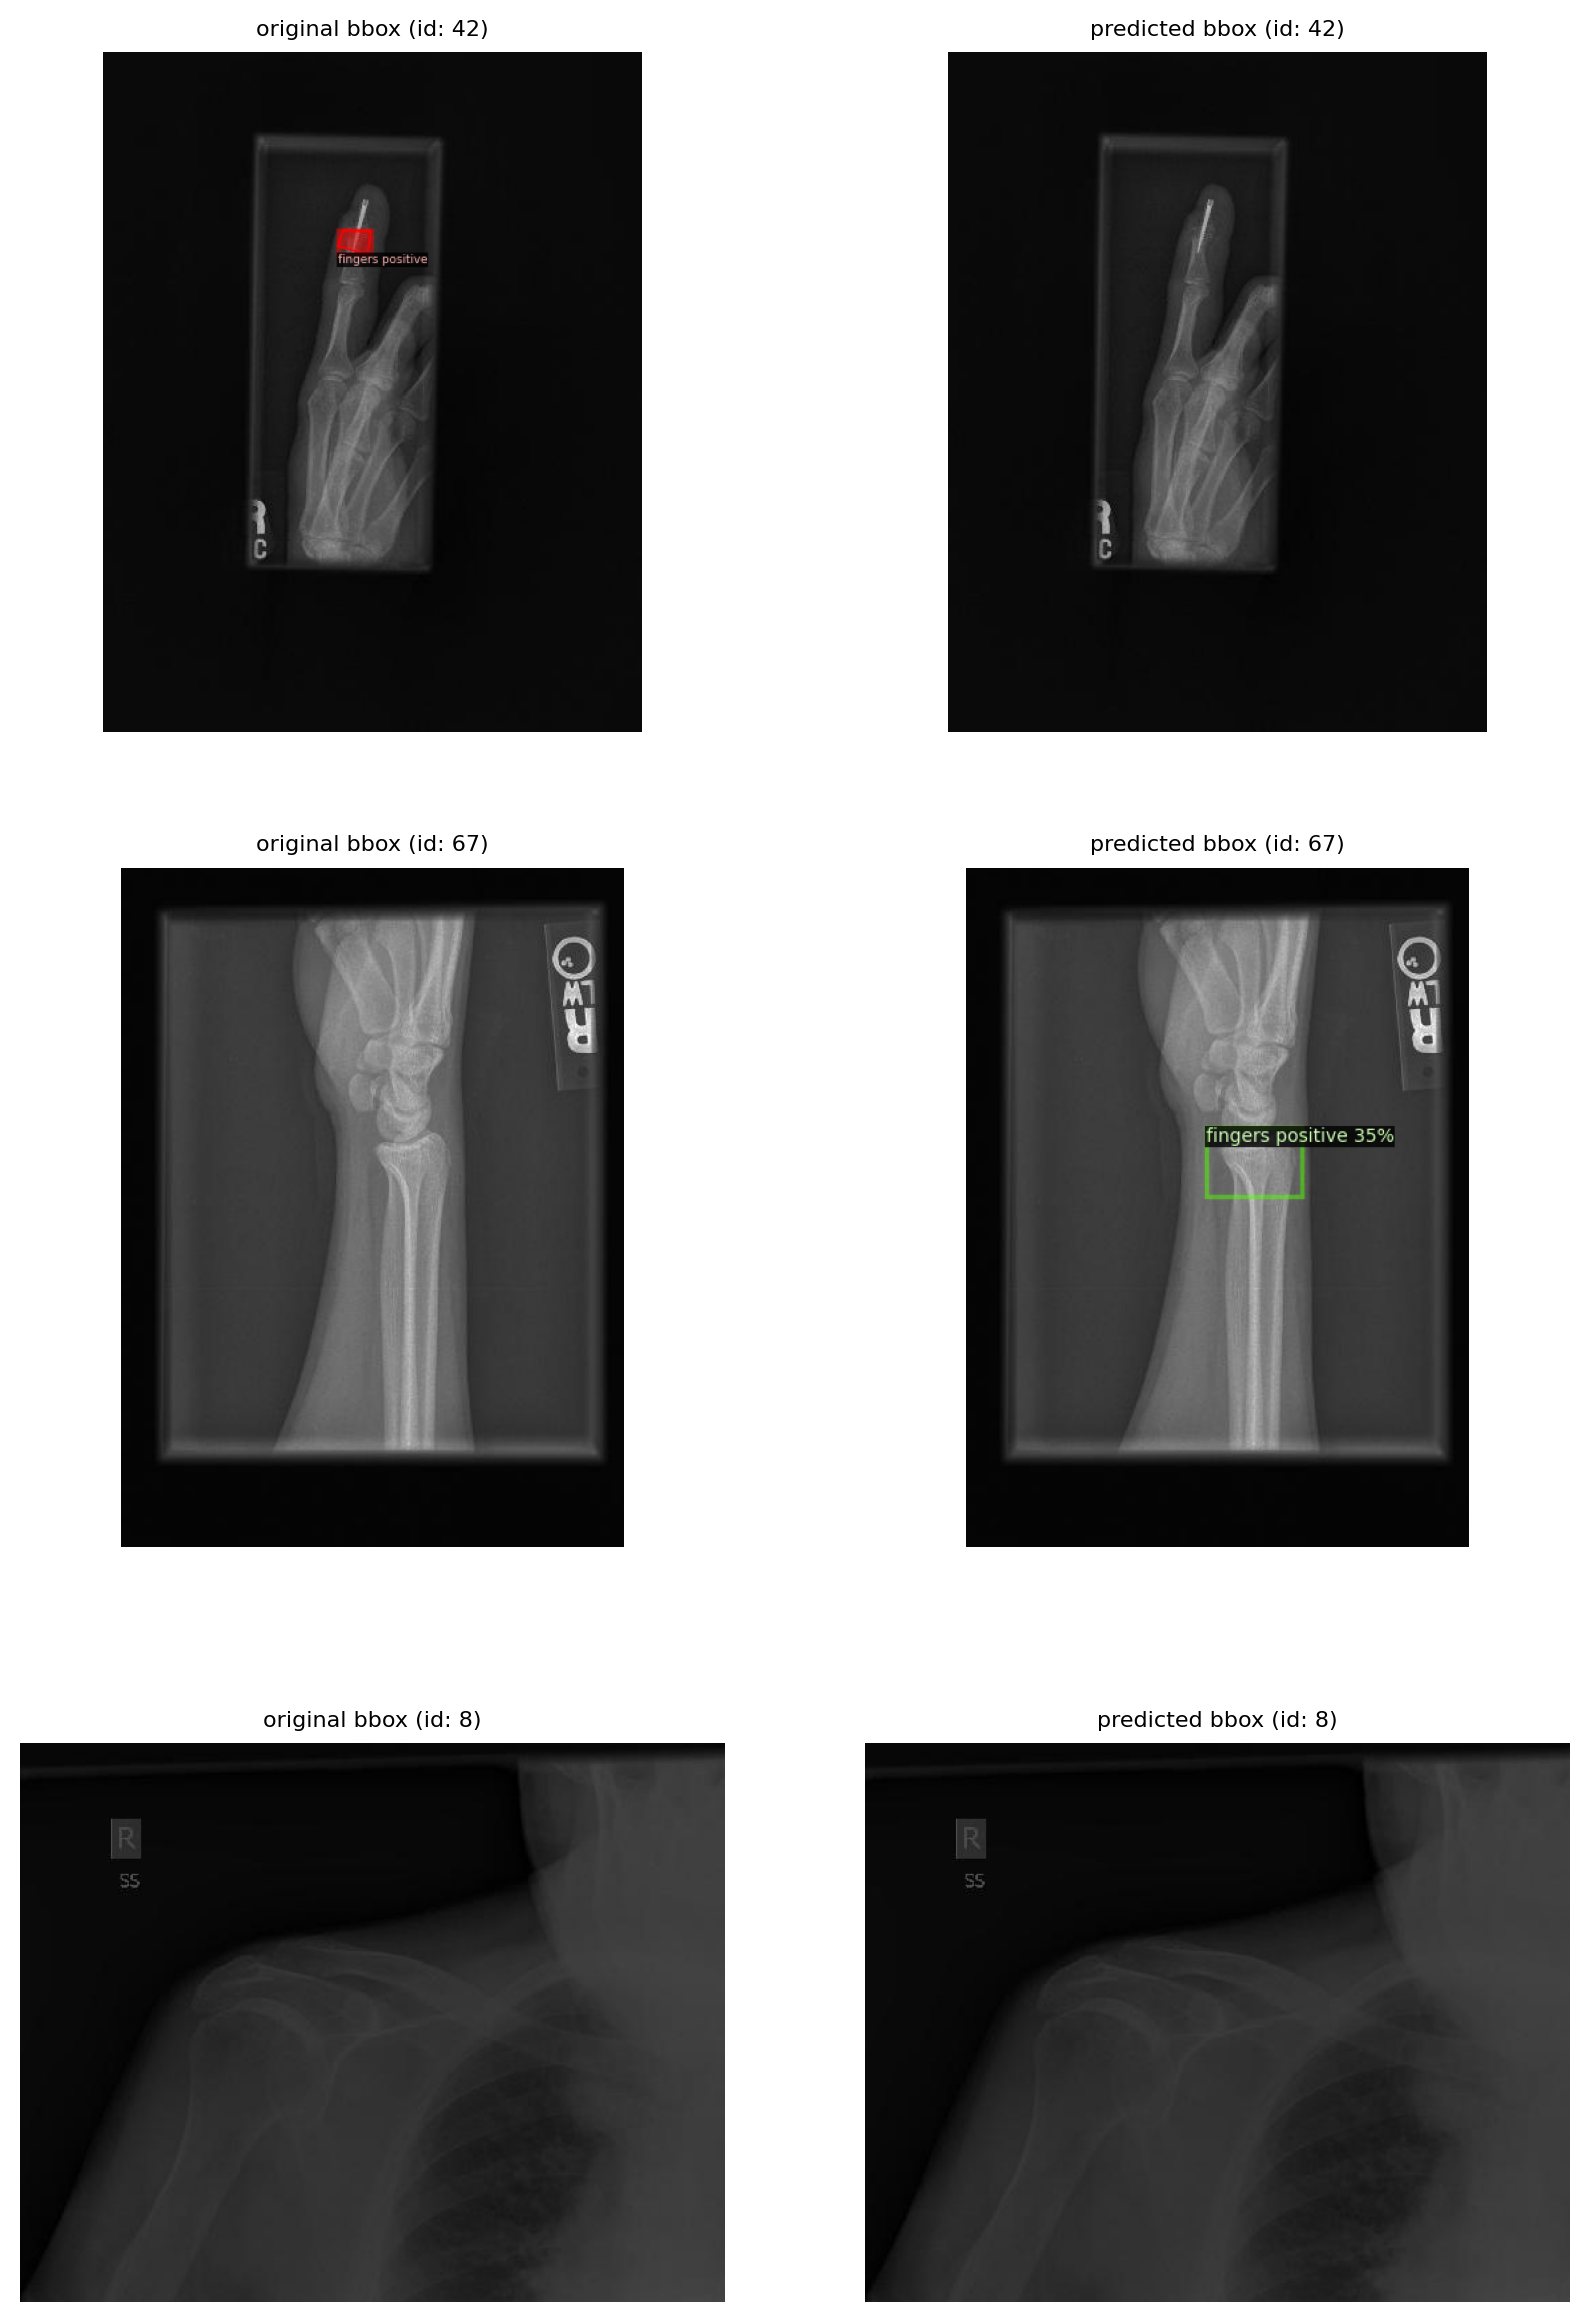

In [13]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 93, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 643, image_scale=1)

# <span style="color:#e74c3c;">Faster R-CNN w/ResNet-50 FPN </span> Model, Training

In [14]:
from detectron2.engine import DefaultTrainer

EPOCHS = 2500
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/14 13:27:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:02, 64.9MB/s]                           


[01/14 13:27:37 d2.engine.train_loop]: Starting training from iteration 0
[01/14 13:27:42 d2.utils.events]:  eta: 0:11:14  iter: 19  total_loss: 2.439  loss_cls: 2.234  loss_box_reg: 0.02202  loss_rpn_cls: 0.1704  loss_rpn_loc: 0.01253    time: 0.2747  last_time: 0.3122  data_time: 0.0150  last_data_time: 0.0064   lr: 1.9981e-05  max_mem: 5912M
[01/14 13:27:48 d2.utils.events]:  eta: 0:11:04  iter: 39  total_loss: 1.498  loss_cls: 1.328  loss_box_reg: 0.02339  loss_rpn_cls: 0.09667  loss_rpn_loc: 0.01382    time: 0.2730  last_time: 0.3264  data_time: 0.0070  last_data_time: 0.0062   lr: 3.9961e-05  max_mem: 5912M
[01/14 13:27:53 d2.utils.events]:  eta: 0:10:53  iter: 59  total_loss: 0.4672  loss_cls: 0.2897  loss_box_reg: 0.01977  loss_rpn_cls: 0.1684  loss_rpn_loc: 0.01317    time: 0.2719  last_time: 0.2521  data_time: 0.0064  last_data_time: 0.0011   lr: 5.9941e-05  max_mem: 5912M
[01/14 13:27:58 d2.utils.events]:  eta: 0:10:45  iter: 79  total_loss: 0.2613  loss_cls: 0.09902  loss_b

In [15]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[01/14 13:38:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# <span style="color:#e74c3c;">Faster R-CNN w/ResNet-50 FPN </span> Training Results

In [16]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [17]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

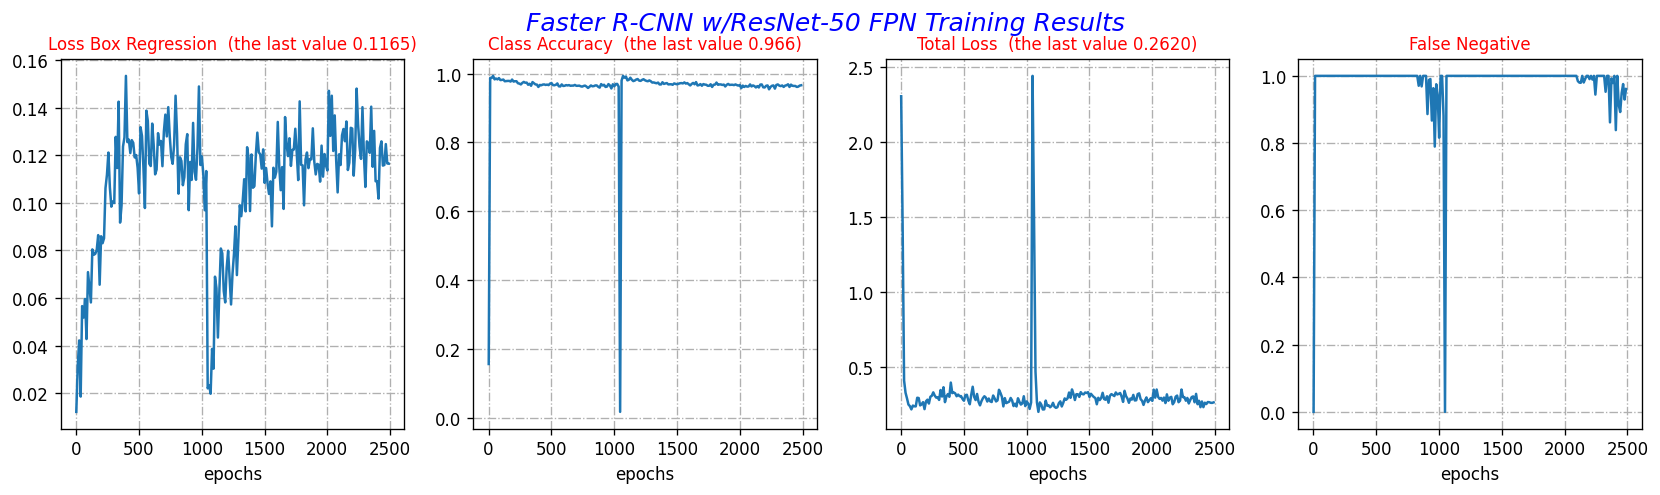

In [18]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)

fig.suptitle('Faster R-CNN w/ResNet-50 FPN Training Results', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

# <span style="color:#e74c3c;">Faster R-CNN w/ResNet-50 FPN </span> Test Results

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[01/14 13:38:32 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [01/14 13:38:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 13:38:32 d2.data.datasets.coco]: Loaded 169 images in COCO format from ../input/bone-fracture-detection-detection-coco-annots/test_annotations.coco.json
[01/14 13:38:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/14 13:38:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/14 13:38:32 d2.data.common]: Serializing 169 elements to byte tensors and concatenating them all ...
[01/14 13:38:32 d2.data.common]: Serialized dataset takes 0.05 MiB
[01/14 13:38:32 d2.evaluation.evaluator]: Start inference on 169 batches
[01/14 13:38:33 d2.evaluation.evaluator]: Infer

OrderedDict([('bbox',
              {'AP': 3.3816108843491572,
               'AP50': 9.444254161581949,
               'AP75': 0.21726690043521726,
               'APs': 0.34904577414263166,
               'APm': 2.933158467763469,
               'APl': 7.165880755046638,
               'AP-bones': nan,
               'AP-elbow positive': 0.5101921956901573,
               'AP-fingers positive': 1.8265039233353701,
               'AP-forearm fracture': 8.623124152803609,
               'AP-humerus': nan,
               'AP-humerus fracture': 4.252972665687622,
               'AP-shoulder fracture': 4.16048072941427,
               'AP-wrist positive': 0.9163916391639165})])

# <span style="color:#e74c3c;">Faster R-CNN w/ResNet-50 FPN </span> Test Predictions

In [20]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [01/14 13:38:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/14 13:38:43 d2.data.datasets.coco]: Loaded 169 images in COCO format from ../input/bone-fracture-detection-detection-coco-annots/test_annotations.coco.json


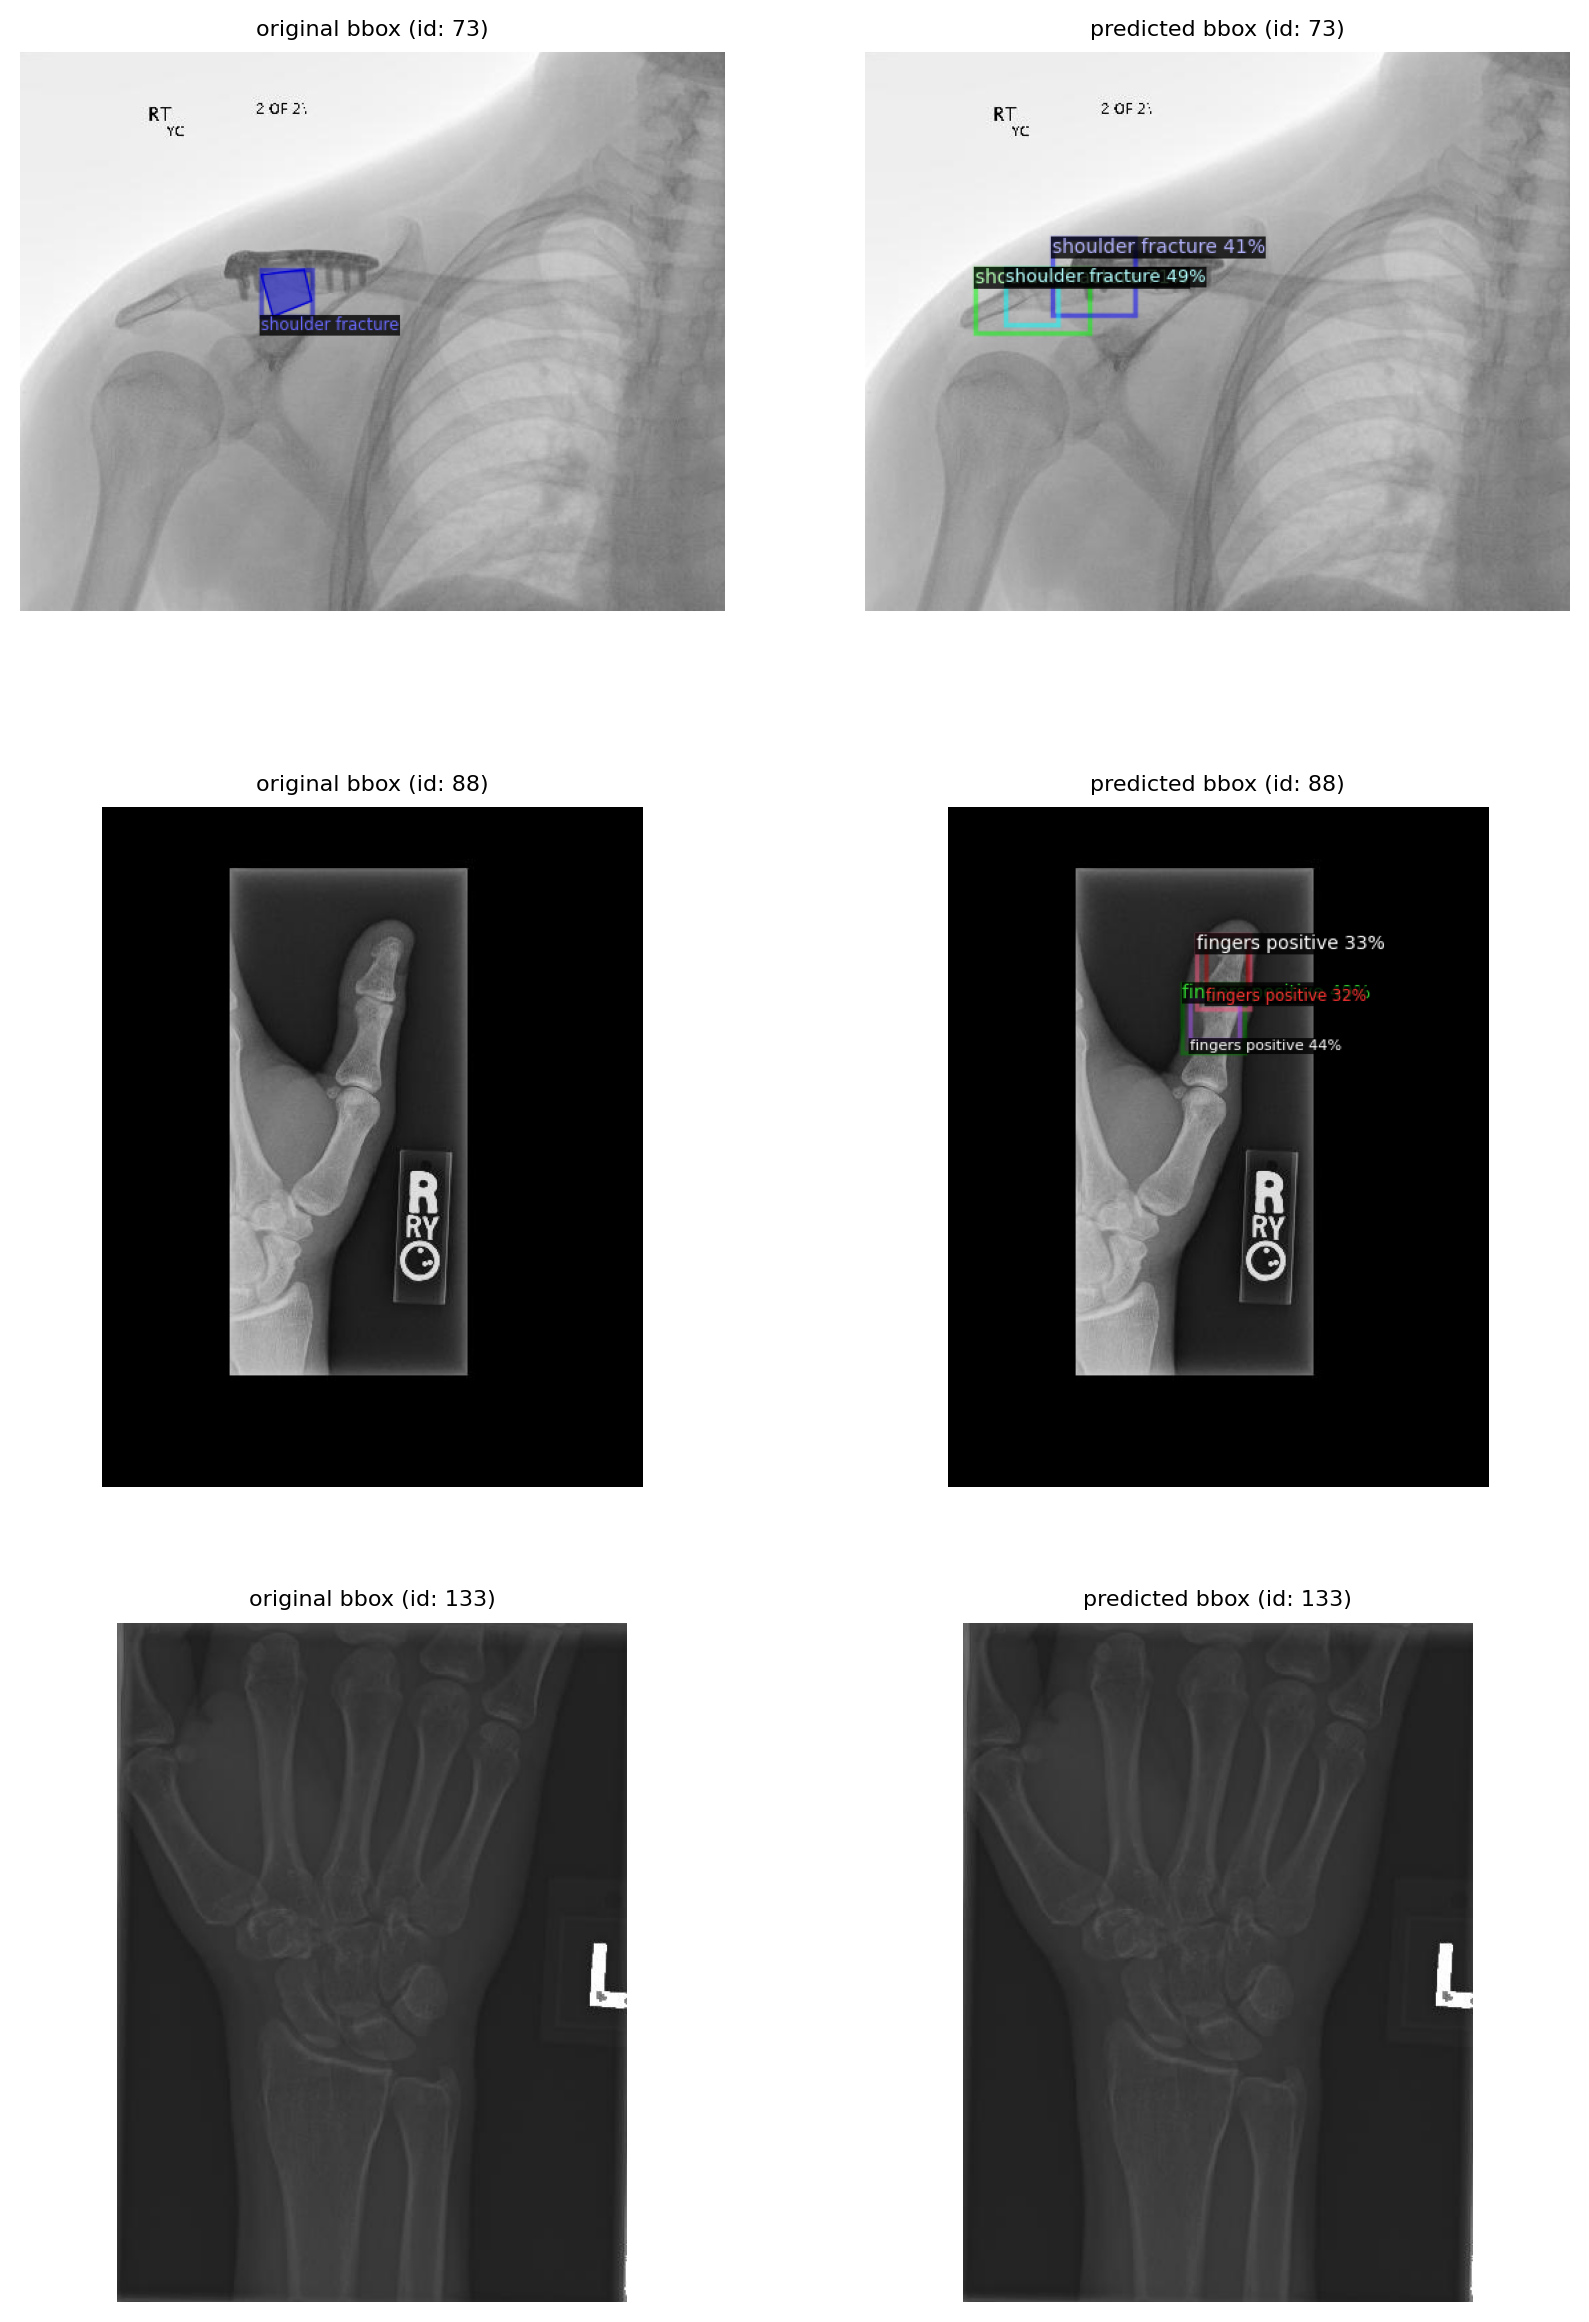

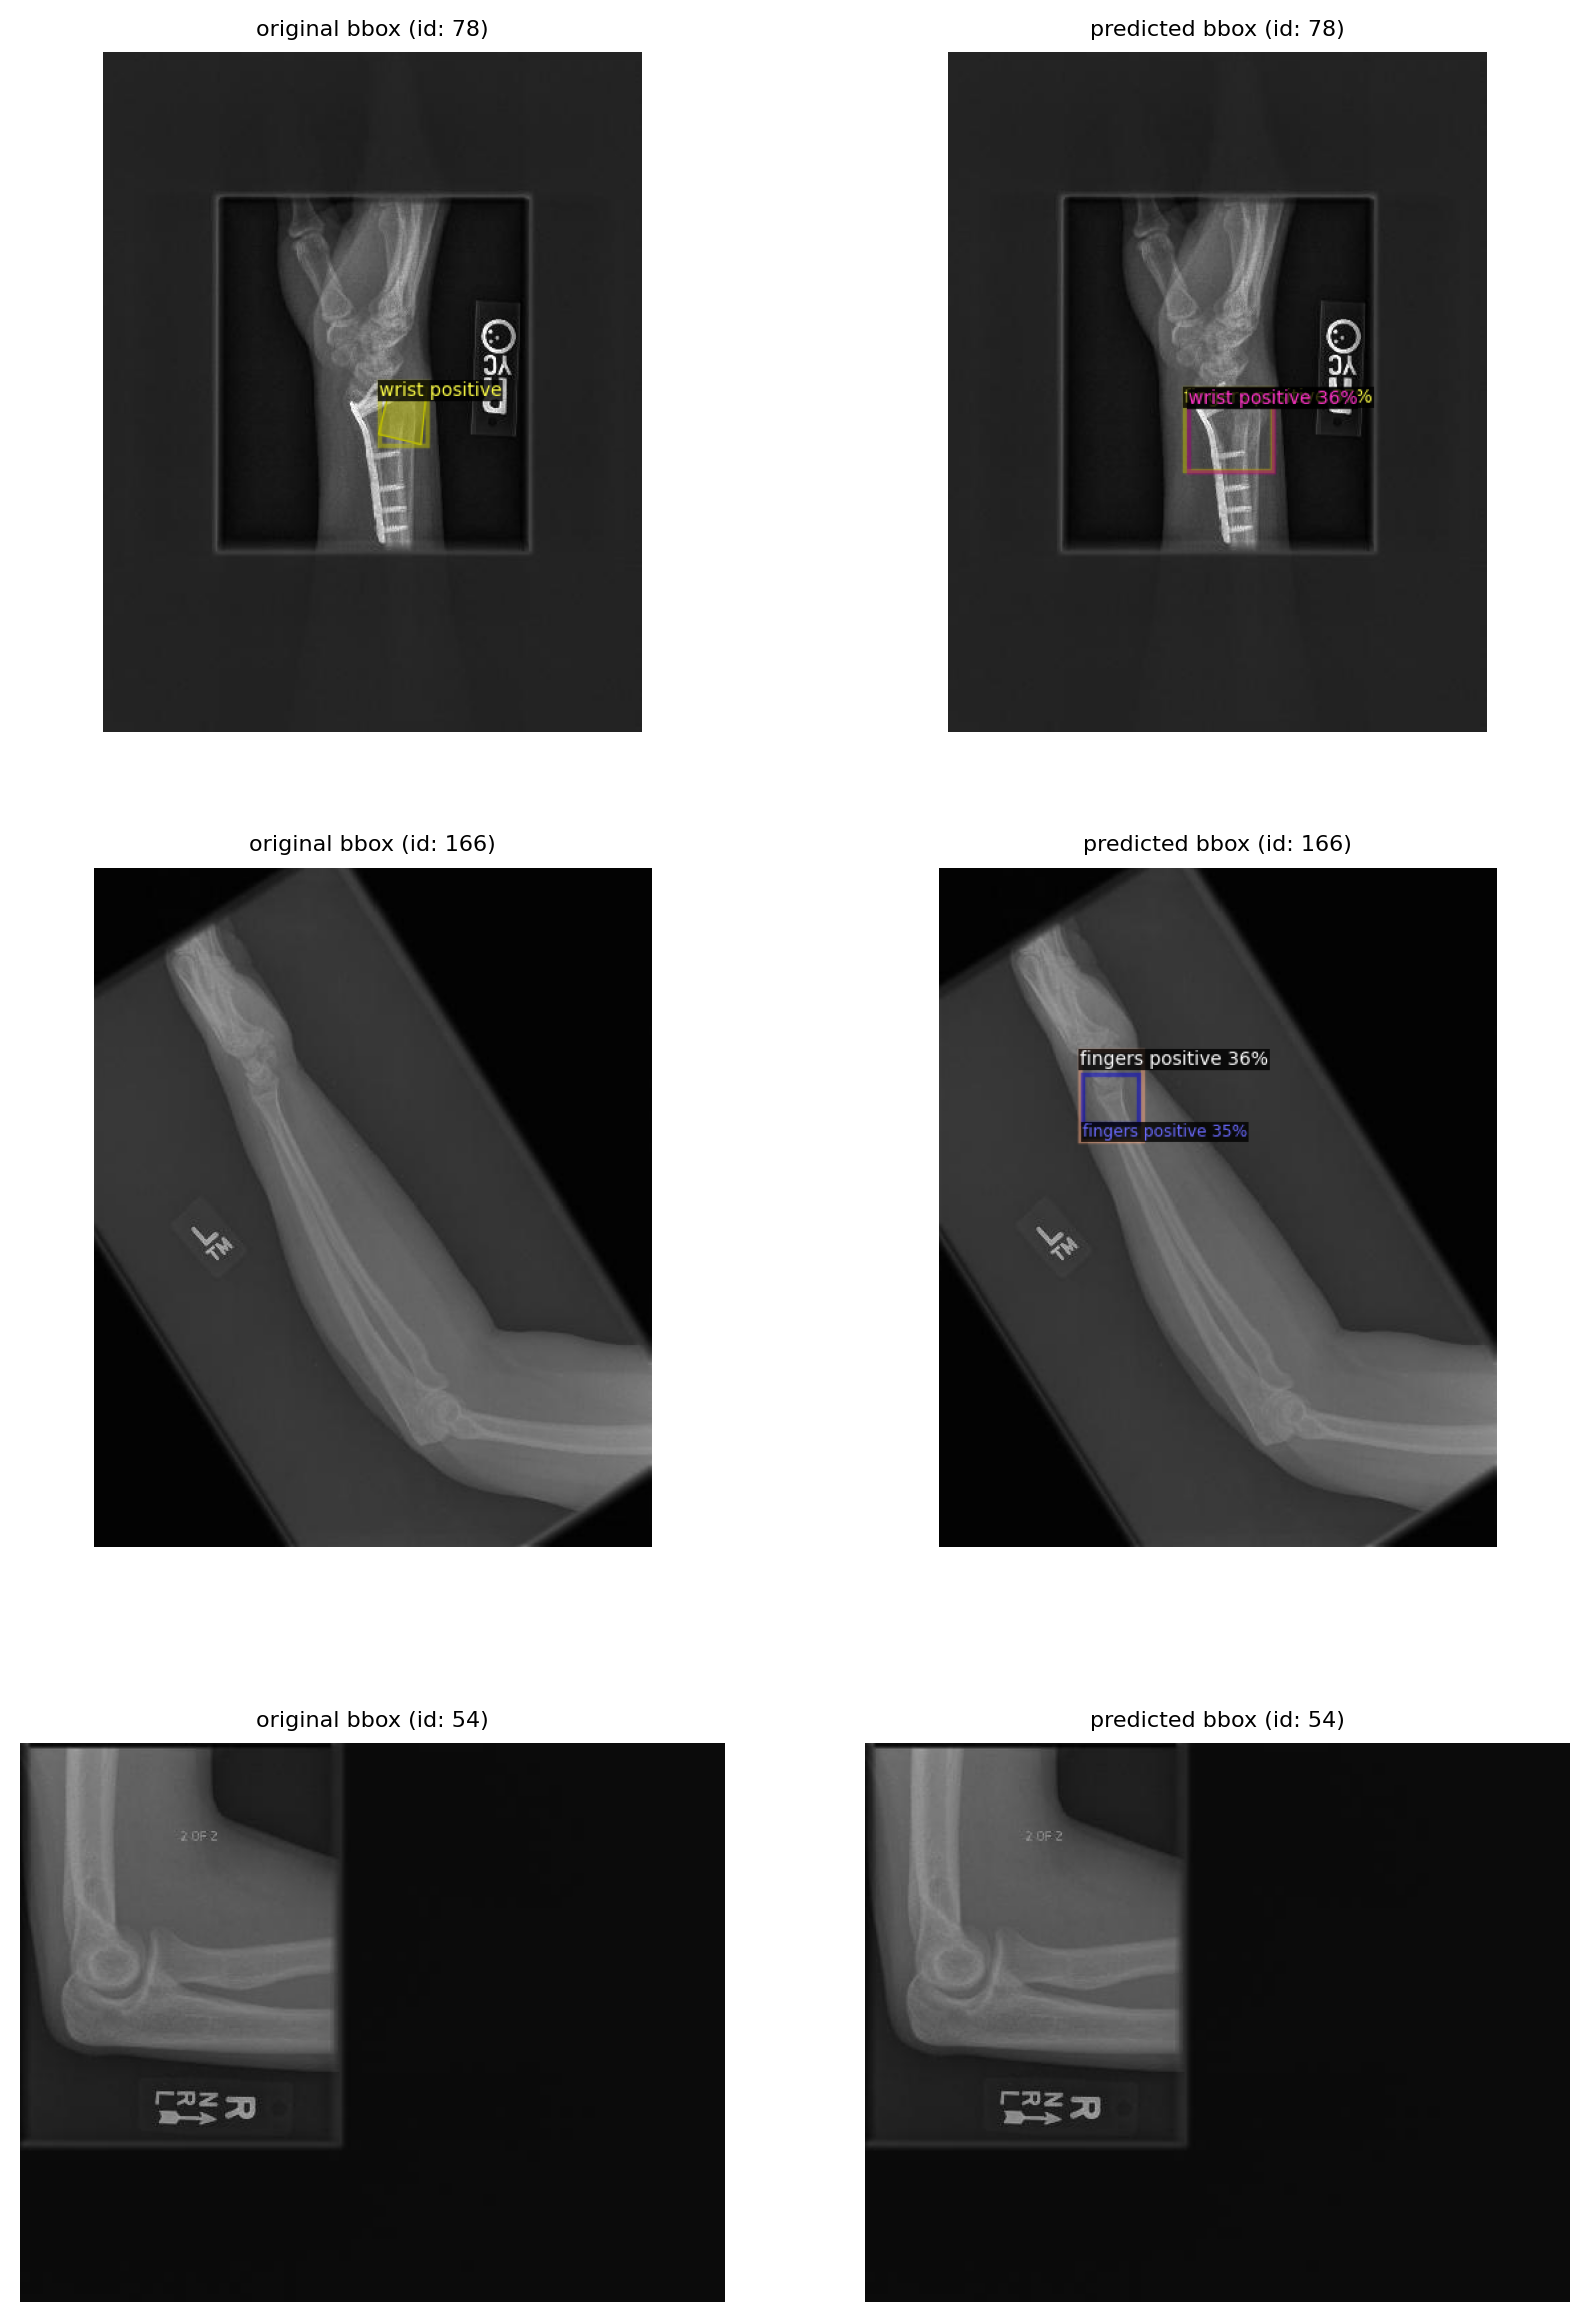

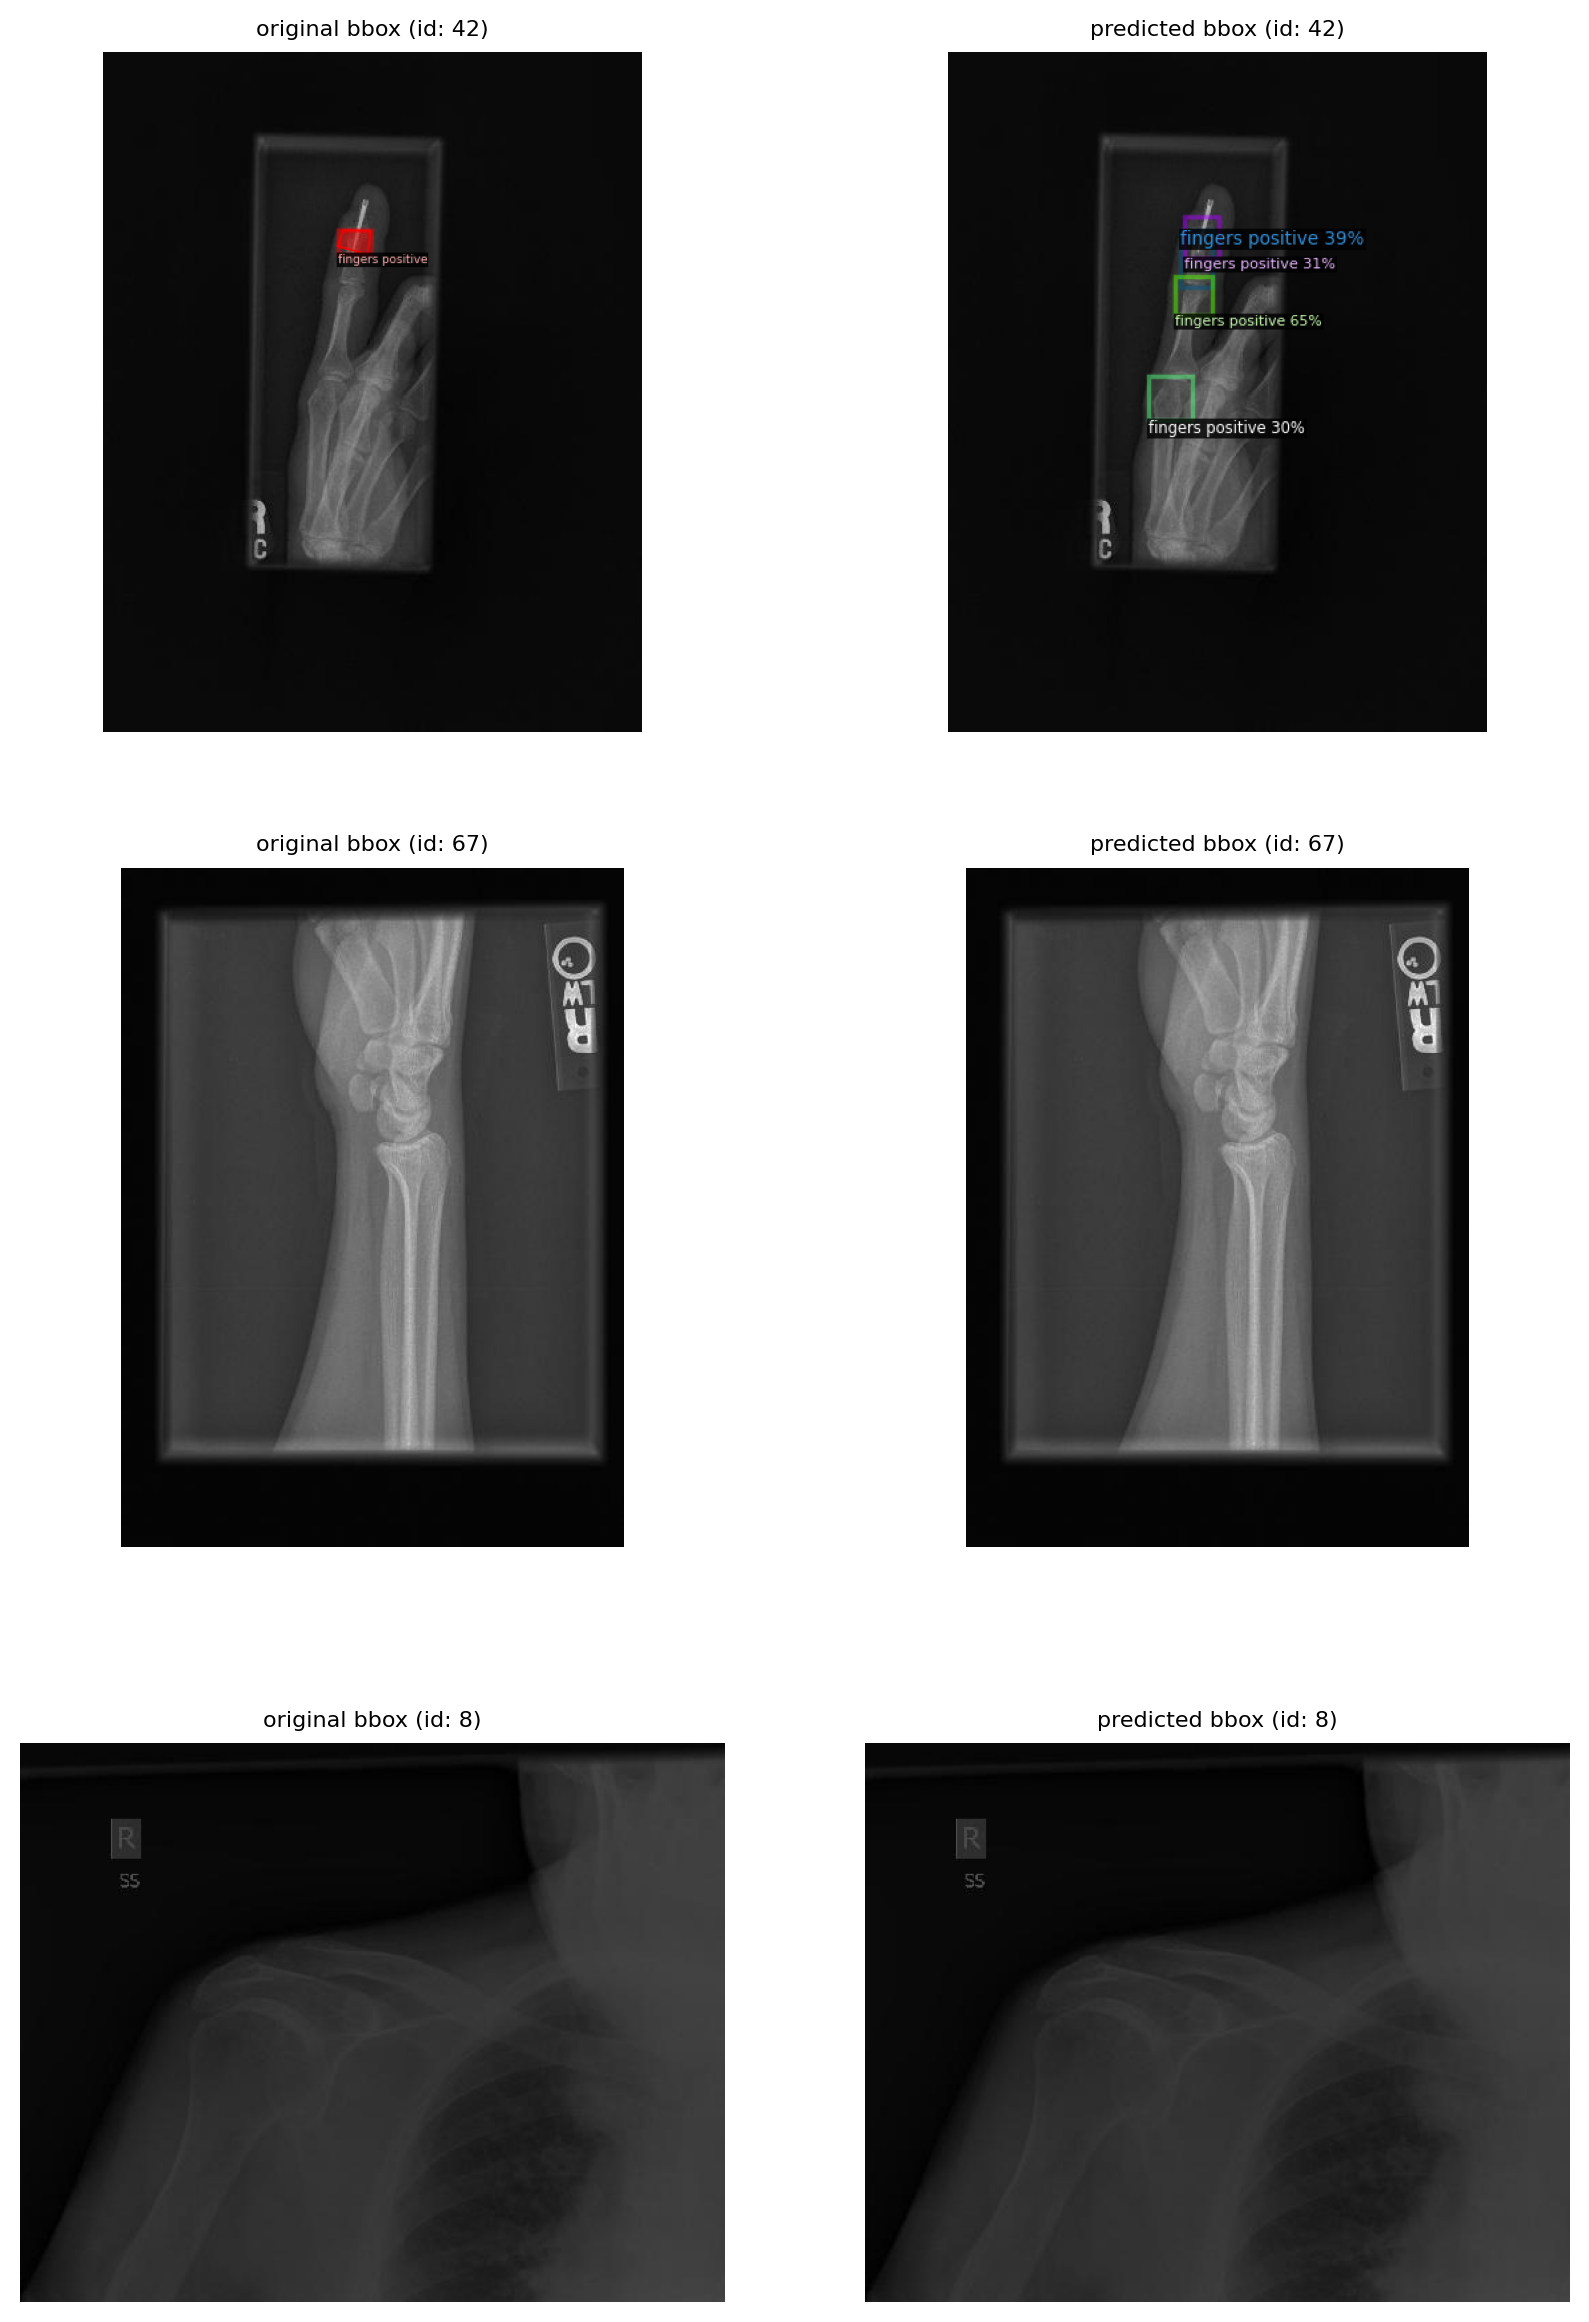

In [21]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 93, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 643, image_scale=1)